In [58]:
import pandas as pd
import numpy as np

file_path = "teste1.xlsx"

data = pd.read_excel(file_path)

# Substituindo os valores da coluna 'Ploidia' de 'euploide' e 'aneuploide' para 1 e 0
data['Ploidia'] = data['Ploidia'].replace({'Euplóide': 1, 'Aneuplóide': 0})

# Removendo a letra D da coluna Estágio para ficar somente números representado o dia
data['Estágio'] = data['Estágio'].str.replace("D", "", regex=False)
data['Estágio'] = pd.to_numeric(data['Estágio'], errors='coerce')

# Substituindo a classificação Morfo pelo seu grupo de 1 a 4
def classificar_morfo(valor):
    prefixo = valor[0]
    sufixo = valor[1:]

    if sufixo == "AA" and prefixo in "3456":
        return 1  # Excelente
    elif sufixo in ["AB", "BA"] and prefixo in "3456":
        return 2  # Bom
    elif sufixo in ["BB", "AC", "CA"] and prefixo in "3456":
        return 3  # Médio
    else:
        return 4  # Ruim

# Aplicar a função diretamente na coluna 'Morfo'
data['Morfo'] = data['Morfo'].apply(classificar_morfo)

# Selecionando apenas as colunas numéricas
numeric_columns = data.select_dtypes(include=[np.number])

# Salvando em uma nova planilha
output_file = "PlanilhaNumerica.xlsx"
numeric_columns.to_excel(output_file, index=False)

print(f"Planilha somente com dados numéricos salva como: {output_file}")

Planilha somente com dados numéricos salva como: PlanilhaNumerica.xlsx


C:\Users\maria.ferreira\AppData\Local\Temp\ipykernel_16592\3053583842.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Ploidia'] = data['Ploidia'].replace({'Euplóide': 1, 'Aneuplóide': 0})


Calculando LIME + Probabilidades para cada embrião...

=== MÉTRICAS DE DESEMPENHO ===
Acurácia: 0.556
AUC (baseado na sigmoid): 0.722
Recall Euploide (Sensibilidade): 0.333
Recall Aneuploide (Especificidade): 1.000

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       1.00      0.33      0.50         6

    accuracy                           0.56         9
   macro avg       0.71      0.67      0.55         9
weighted avg       0.81      0.56      0.53         9



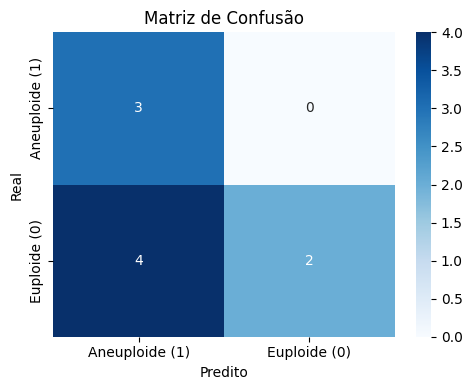

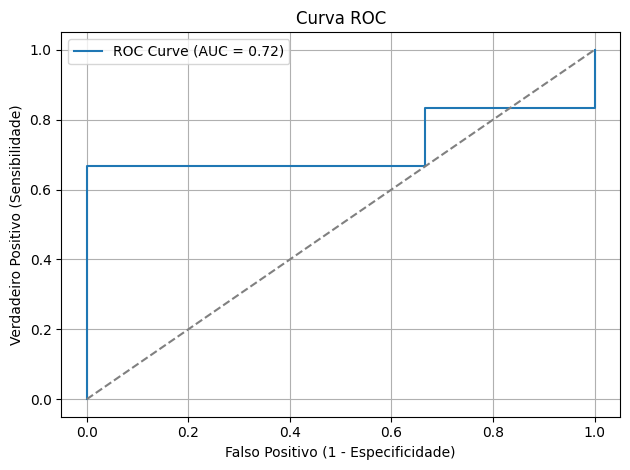


 Concluído com sucesso!
Arquivo salvo como: Planilha_Com_LIME_Porcentagem.xlsx


In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
import numpy as np

df = pd.read_excel("PlanilhaNumerica.xlsx")
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

X = df.drop(columns=["Ploidia"], errors="ignore")
y_true = df["Ploidia"]

colunas_treinadas = scaler.feature_names_in_
for col in colunas_treinadas:
    if col not in X.columns:
        X[col] = 0  

X = X[colunas_treinadas]
X_scaled = scaler.transform(X)

classes_preditas = modelo.predict(X_scaled)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=colunas_treinadas,
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

print("Calculando LIME + Probabilidades para cada embrião...")
prob_euploidia = []

for i in range(len(X_scaled)):
    _ = explainer.explain_instance(X_scaled[i], modelo.predict_proba, num_features=len(colunas_treinadas))
    
    prob = modelo.predict_proba(X_scaled[i].reshape(1, -1))[0][1]
    prob_euploidia.append(round(prob * 100, 2))

df["Classe_Prevista"] = classes_preditas
df["Prob_Euploidia_LIME"] = prob_euploidia

prob_raw = modelo.predict_proba(X_scaled)[:, 1]
acc = accuracy_score(y_true, classes_preditas)
auc = roc_auc_score(y_true, prob_raw)

cm = confusion_matrix(y_true, classes_preditas)
tn, fp, fn, tp = cm.ravel()
recall_euploide = tp / (tp + fn) if (tp + fn) > 0 else 0
recall_aneuploide = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n=== MÉTRICAS DE DESEMPENHO ===")
print(f"Acurácia: {acc:.3f}")
print(f"AUC (baseado na sigmoid): {auc:.3f}")
print(f"Recall Euploide (Sensibilidade): {recall_euploide:.3f}")
print(f"Recall Aneuploide (Especificidade): {recall_aneuploide:.3f}")
print("\n=== Classification Report ===")
print(classification_report(y_true, classes_preditas))

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Aneuploide (0)", "Euploide (1)"],
            yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(y_true, prob_raw)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo (1 - Especificidade)")
plt.ylabel("Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df.to_excel("Planilha_Com_LIME_Porcentagem.xlsx", index=False)

print("\n Concluído com sucesso!")
print("Arquivo salvo como: Planilha_Com_LIME_Porcentagem.xlsx")

Probabilidades previstas para amostras Euploide (classe 1):
[0.000433   0.00012142 0.00088725]

Probabilidades e classes reais para todas as amostras:
Amostra 0: Classe real = 1, Probabilidade classe 1 = 0.0004
Amostra 1: Classe real = 1, Probabilidade classe 1 = 0.0001
Amostra 2: Classe real = 1, Probabilidade classe 1 = 0.0009
Amostra 3: Classe real = 0, Probabilidade classe 1 = 0.0000
Amostra 4: Classe real = 0, Probabilidade classe 1 = 0.2611
Amostra 5: Classe real = 0, Probabilidade classe 1 = 0.0002
Amostra 6: Classe real = 0, Probabilidade classe 1 = 0.8825
Amostra 7: Classe real = 0, Probabilidade classe 1 = 0.0047
Amostra 8: Classe real = 0, Probabilidade classe 1 = 0.9525


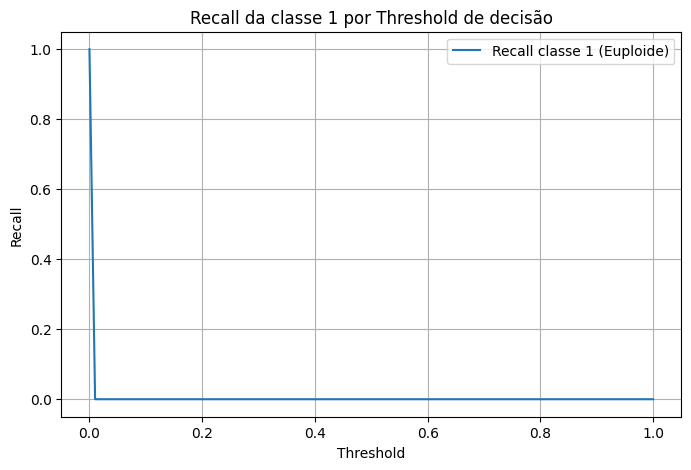

In [60]:
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Carregar dados e modelo
df = pd.read_excel("PlanilhaNumerica.xlsx")
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

X = df.drop(columns=["Ploidia"], errors="ignore")
y_true = df["Ploidia"]

colunas_treinadas = scaler.feature_names_in_
for col in colunas_treinadas:
    if col not in X.columns:
        X[col] = 0  
X = X[colunas_treinadas]

X_scaled = scaler.transform(X)

# Probabilidades preditas para a classe 1
prob_raw = modelo.predict_proba(X_scaled)[:, 1]

# Mostrar probabilidades para amostras reais da classe 1 (Euploide)
prob_euploides = prob_raw[y_true == 1]
print("Probabilidades previstas para amostras Euploide (classe 1):")
print(prob_euploides)

# Mostrar probabilidade e classe real para todas as amostras
print("\nProbabilidades e classes reais para todas as amostras:")
for i, (true_label, prob) in enumerate(zip(y_true, prob_raw)):
    print(f"Amostra {i}: Classe real = {true_label}, Probabilidade classe 1 = {prob:.4f}")

# Avaliar recall da classe 1 para diferentes thresholds
thresholds = np.linspace(0, 1, 101)
recalls = []

for thr in thresholds:
    preds = (prob_raw >= thr).astype(int)
    cm = confusion_matrix(y_true, preds)
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    recalls.append(recall)

plt.figure(figsize=(8,5))
plt.plot(thresholds, recalls, label="Recall classe 1 (Euploide)")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall da classe 1 por Threshold de decisão")
plt.grid(True)
plt.legend()
plt.show()


In [64]:
# TENTATIVA FINAL

import pandas as pd
import joblib
import numpy as np

# === CONFIGURAÇÕES ===
ARQUIVO_ENTRADA = "teste2.xlsx"  # Nome do arquivo de entrada
ARQUIVO_SAIDA = "Planilha_Com_Classe_Probabilidade.xlsx"  # Nome do arquivo de saída

print("\n=== CLASSIFICAÇÃO DE EMBRIÕES COM REDE NEURAL (MLP) ===")

# === CARREGAR DADOS ===
print(f"Lendo o arquivo: {ARQUIVO_ENTRADA}...")
df = pd.read_excel(ARQUIVO_ENTRADA)

# === CARREGAR MODELO E SCALER ===
print("Carregando modelo de Rede Neural (MLP)...")
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

# === PREPARAR DADOS ===
print("Preparando dados...")
X = df.drop(columns=["Ploidia"], errors="ignore")
colunas_treinadas = scaler.feature_names_in_

# Garantir que todas as colunas estão presentes
for col in colunas_treinadas:
    if col not in X.columns:
        X[col] = 0  

X = X[colunas_treinadas]
X_scaled = scaler.transform(X)

# === CLASSIFICAÇÃO ===
print("Realizando classificações...")
classes_preditas = modelo.predict(X_scaled)
probabilidades = modelo.predict_proba(X_scaled)[:, 1]  # Probabilidade de classe 1 (Euploide)
probabilidades_percentual = np.round(probabilidades * 100, 2)

# === INSERIR RESULTADOS NA PLANILHA ===
df["Classe_Prevista"] = classes_preditas
df["Prob_Euploidia_%"] = probabilidades_percentual

# === SALVAR RESULTADO ===
df.to_excel(ARQUIVO_SAIDA, index=False)
print(f"\nClassificação concluída com sucesso!")
print(f"Arquivo salvo como: {ARQUIVO_SAIDA}")



=== CLASSIFICAÇÃO DE EMBRIÕES COM REDE NEURAL (MLP) ===
Lendo o arquivo: teste2.xlsx...
Carregando modelo de Rede Neural (MLP)...
Preparando dados...
Realizando classificações...

Classificação concluída com sucesso!
Arquivo salvo como: Planilha_Com_Classe_Probabilidade.xlsx
